In [4]:
import numpy as np
from IPython.display import Image
from graphviz import Digraph

def graph_parse(func):
        def tensor_check_and_operate(*args, **kwargs):
            tensors = [isinstance(arg, Tensor) for arg in args] #figure out which of the arguments are elements
            args = [args[i] if val else Tensor(args[i],name= 'num', track_grad = False) for i, val in enumerate(tensors)]
            values = tuple([args[i].value for i in range(len(args))]) #get the values of each argument
            #print(values)
            #print([i for i, val in enumerate(elements) if val])
            out = Tensor(func(*values, **kwargs), args, func.__name__) #create element with the output value of function and correct parents and creator function
            #print(out.parents)
            return out
        return tensor_check_and_operate
    
class Tensor(object):
    """A class representing an element of the computation graph
       with value."""
    
    
    def __init__(self, value, parents=None, function='NA', name = '', track_grad = True):
        if isinstance(value, list):
            self.value = np.array(value)
        elif isinstance(value, np.ndarray):
            self.value = value
        else:
            self.value = np.array([value])
        self.value = np.array(value)
        self.parents = parents
        self.function = function
        self.grad = 0
        self.name = name
        self.track_grad = track_grad
       
    @graph_parse
    def __add__(self, x):
        return self+x
    
    @graph_parse
    def __radd__(self,x):
        return self+x
        
    @graph_parse      
    def __mul__(self, x):
        return self*x
    @graph_parse
    def __rmul__(self,x):
        return self*x
    
    @graph_parse
    def __truediv__(self,x):
        return self/x
    
    @graph_parse
    def __sub__(self, x):
        return self-x
    
    @graph_parse
    def __pow__(self,x):
        return self ** x
    
    def reshape(self,dims):
        self.value.reshape(dims)
    
    def __str__(self):
        return str("Tensor(shape: " + str(self.value.shape) + ', val: ' + str(self.value)+', grad: '+(str(self.grad.value) if isinstance(self.grad, Tensor) else str(self.grad))+', function: '+str(self.function))
    
@graph_parse    
def log(num, base):
    assert base is not 1
    return (np.log(num)/np.log(base))

@graph_parse  
def sin(theta):
    return np.sin(theta)

@graph_parse  
def cos(theta):
    return np.cos(theta)

@graph_parse  
def tan(theta):
    return np.tan(theta)

@graph_parse
def matmul(a,b):
    return np.matmul(a,b)

@graph_parse
def hadamard(a,b):
    return a*b

@graph_parse
def transpose(a):
    return np.transpose(a)

@graph_parse
def reduce_sum(a):
    return np.sum(a)

def backprop(e : Tensor, grad = Tensor(1)):
    e.grad = (grad + e.grad) if isinstance(e.grad, Tensor) else grad
    e.grad.name = grad.name
    
    f_name = e.function if e.function is not None else None
    if e.parents is not None:
        for i, p in enumerate(e.parents):
            if p.track_grad:
                if f_name == '__add__':
                    #backprop(p, grad = e.grad)
                    parent_grad = e.grad
                elif f_name == '__mul__' or f_name =='__rmul__':
                    #backprop(p, grad = e.grad*(e.parents[1-i]))
                    parent_grad = e.grad*(e.parents[1-i])
                elif f_name == '__sub__':
                    if i == 0:
                        #backprop(p, grad = e.grad)
                        parent_grad = e.grad
                    else:
                        #backprop(p, grad = e.grad*(-1))
                        parent_grad = e.grad*(-1)
                elif f_name == '__truediv__':
                    if i == 0:
                        #backprop(p, grad = e.grad*(Element(1,None, None)/e.parents[1]))
                        parent_grad = e.grad*(Tensor(1)/e.parents[1])
                    else:
                        #backprop(p, grad = e.grad*(-1)*e.parents[0]*p**-2)
                        parent_grad = e.grad*(-1)*e.parents[0]*p**-2
                elif f_name == '__pow__':
                    if i == 0:
                        #backprop(p, grad = e.grad*(e.parents[1])*p**(e.parents[1]-1))
                        parent_grad = e.grad*(e.parents[1])*p**(e.parents[1]-1)
                    else:
                        #backprop(p, grad = e.grad*0)
                        parent_grad = e.grad*(e.parents[0]**p)*log(e.parents[0],np.e)

                elif f_name == 'log':
                    if i == 0:
                        parent_grad = e.grad*(Tensor(1)/p)*log(e.parents[1],np.e)
                    else:
                        parent_grad = e.grad*(-1)*(log(e.parents[0],np.e)/(p*np.log(p,np.e)**2))
                        
                elif f_name == 'sin':
                    parent_grad = e.grad*(cos(p))
                elif f_name == 'cos':
                    parent_grad = e.grad*(sin(p)*(-1))
                elif f_name == 'tan':
                    parent_grad = e.grad*(Tensor(1)/(cos(p)**2))
                    
                elif f_name =='matmul':
                    if i == 0:
                        parent_grad = matmul(e.grad, transpose(e.parents[1]))
                    else:
                        parent_grad = matmul(transpose(e.parents[0]),e.grad)
                        
                elif f_name == 'transpose':
                    parent_grad = transpose(e.grad)
                    
                elif f_name == 'hadamard':
                    parent_grad = hadamard(e.parents[1-i], e.grad)
                    
                elif f_name == 'reduce_sum':
                    parent_grad = e.grad * np.ones_like(p.value)
                        
                parent_grad.name = p.name+'grad'
                #print(parent_grad)
                backprop(p, grad = parent_grad)

                
def traceback(e : Tensor, first = True):
    
    l = [0,[]]
    l[0] = (e.name, e.value, e.grad.value if isinstance(e.grad, Tensor) else e.grad, e.function)
    if e.parents is not None:
        for parent in e.parents:
            t = traceback(parent, first = False)
            l[1].append(t[0])
            l[1].append(t[1])
    
    
    return l
            
def graph_print(l, name = False, value = True, grad = False, function = True):
    
    while True:
        isList = [isinstance(l[i], list) for i in range(len(l))]
        if False in isList:
            idxs = [i for i, val in enumerate(isList) if not val]
            idxs.reverse()
            to_print = []
            for i in idxs:
                info = l.pop(i)    
                to_print.append((('n: %6s ' % info[0]) if name else '') + 
                                (('val: %5.3f ' %info[1]) if value else '') + 
                                (('g: %5.3f ' %info[2]) if grad else '')+ 
                                (('fun: %4s' % info[3].replace('_','')) if function else ''))
            to_print.reverse()
            print(to_print)

        elif l == []:
            break
        else:
            t = []
            for i in range(len(l)):
                for j in range(len(l[i])):
                    t.append(l[i][j])
            l = t
                

def grad_str(t: Tensor):
    return str(t.grad.value) if isinstance(t.grad, Tensor) else str(t.grad)

def graph_str(t:Tensor):
    return ((t.name+'\n') if t.name is not '' else '') +'val: '+str(t.value)+'\ngrad: '+grad_str(t)+'\nfunc: '+t.function
                
def graph_visualize(t : Tensor, graph = None, counter=0):
    
    if graph is None:
        graph = Digraph('graph')
        graph.node('0',graph_str(t))
        
    my_count = counter
    if t.parents is not None:
        for parent in t.parents:
            counter += 1
            graph.node(str(counter), graph_str(parent))
            graph.edge(str(my_count), str(counter))
            graph,counter = graph_visualize(parent, graph, counter = counter)
            
    if(my_count is not 0):
        return graph,counter
    else:
        return graph

def flush_grads(e: Tensor):
    e.grad = 0
    if e.parents is not None:
        for parent in e.parents:
            flush_grads(parent)

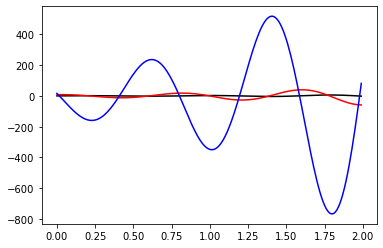

In [7]:
#To test the deriv, you can change the testfunc


import matplotlib.pyplot as plt

def testfunc(x):
    #x = Element(x)
    return (Tensor(np.e)**(x)) * sin(x*8)

def getxgrad(x):
    x = Tensor(x)
    backprop(testfunc(x))
    return x

def gethighergrad(x, order = 2):
    x = Tensor(x)
    backprop(testfunc(x))
    for i in range(order-1):
        y = x.grad
        flush_grads(y)
        backprop(y)
    return x.grad.value

range_lower = 0
range_upper = 2
step = 100

range_tuple = (int(range_lower*step),int(range_upper*step))

plt.plot([i/step for i in range(*range_tuple)],[(testfunc(Tensor(x/step)).value) for x in range(*range_tuple)], 'black')
grads = [(getxgrad(x/step).grad.value) for x in range(*range_tuple)]
plt.plot([i/step for i in range(*range_tuple)],grads, 'red')

grads_2 = [(gethighergrad(x/step,2)) for x in range(*range_tuple)]
plt.plot([i/step for i in range(*range_tuple)],grads_2, 'blue')

plt.show()

In [8]:
x = np.ones((2,2,4)) *3
y = np.array([[1,2],[3,4],[5,6]])
print(x.shape)
print(np.transpose(x,axes=(0,2,1)).shape)
print(np.transpose(x))
print(y)
print(x.shape)
np.transpose(np.matmul(y, x))

(2, 2, 4)
(2, 4, 2)
[[[3. 3.]
  [3. 3.]]

 [[3. 3.]
  [3. 3.]]

 [[3. 3.]
  [3. 3.]]

 [[3. 3.]
  [3. 3.]]]
[[1 2]
 [3 4]
 [5 6]]
(2, 2, 4)


array([[[ 9.,  9.],
        [21., 21.],
        [33., 33.]],

       [[ 9.,  9.],
        [21., 21.],
        [33., 33.]],

       [[ 9.,  9.],
        [21., 21.],
        [33., 33.]],

       [[ 9.,  9.],
        [21., 21.],
        [33., 33.]]])

Tensor(shape: (), val: -2.1273337579063627, grad: 1, function: __mul__


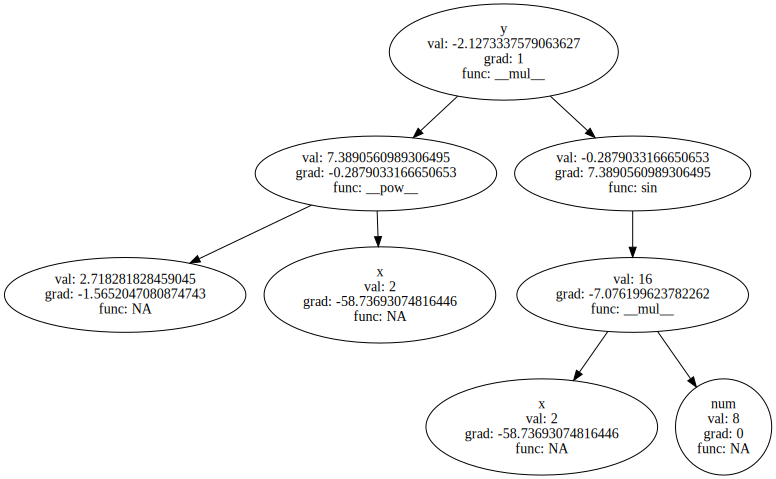

In [9]:
y = testfunc(Tensor(2,name='x'))
y.name='y'
backprop(y)
print(y)
#graph_print(traceback(y))
graph_visualize(y)

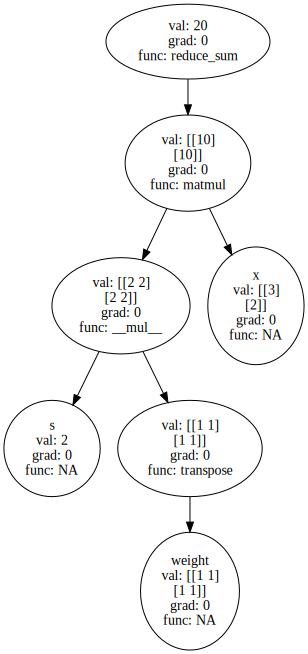

In [10]:
w = Tensor([[1,1],[1,1]],name = 'weight')
x = Tensor([[3],[2]],name = 'x')
s = Tensor(2,name='s')

z = reduce_sum(matmul(s*transpose(w),x))
graph_visualize(z)

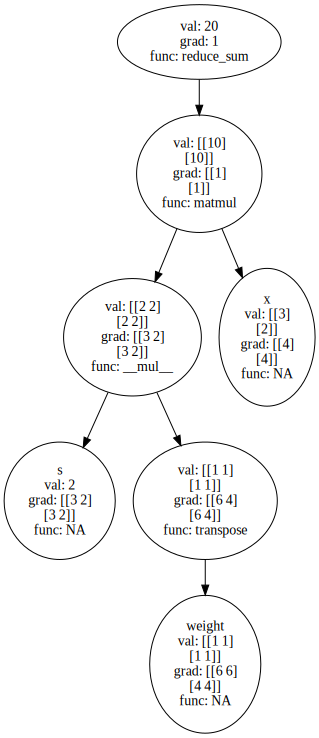

In [11]:
backprop(z)
graph_visualize(z)

#graph_visualize(w.grad)

In [159]:
flush_grads(z)

In [144]:
np.matmul(np.transpose([1,1]), np.transpose([3,2]))

5

In [21]:
import importlib
importlib.reload(Digraph)

TypeError: reload() argument must be a module